Installing packages required to work with Azure ML studio

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
travel_churn_data = pd.read_csv('data/CustomerTravel_org.csv')

travel_churn_data.head()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,34,No,Middle Income,6,No,Yes,0
1,34,Yes,Low Income,5,Yes,No,1
2,37,No,Middle Income,3,Yes,No,0
3,30,No,Middle Income,2,No,No,0
4,30,No,Low Income,1,No,No,0


In [3]:
travel_churn_data.shape

(954, 7)

In [4]:
travel_churn_data.columns

Index(['Age', 'FrequentFlyer', 'AnnualIncomeClass', 'ServicesOpted',
       'AccountSyncedToSocialMedia', 'BookedHotelOrNot', 'Target'],
      dtype='object')

In [5]:
travel_churn_data = travel_churn_data.drop_duplicates()
travel_churn_data.shape

(447, 7)

In [6]:
travel_churn_data['Target'].value_counts()

0    325
1    122
Name: Target, dtype: int64

In [7]:
travel_churn_data['AnnualIncomeClass'].unique()

array(['Middle Income', 'Low Income', 'High Income'], dtype=object)

In [8]:
mapper = {'Low Income': 0,'Middle Income': 1, 'High Income': 2}

In [9]:
travel_churn_data['AnnualIncomeClass'] = travel_churn_data['AnnualIncomeClass'].replace(mapper)

In [10]:
categorical_features = ['FrequentFlyer','AccountSyncedToSocialMedia', 'BookedHotelOrNot']
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown = 'ignore', drop = 'first'))])
preprocessor = ColumnTransformer(transformers = [('cat_tr', categorical_transformer, categorical_features)], 
                                 remainder = StandardScaler())

In [11]:
X = travel_churn_data.drop(labels = ['Target'], axis = 1)
 
y = travel_churn_data['Target']
 
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 124)

Logistic Regression Model is trained and parameters and metrics are logged.
We can display the display the logged parameters and metrics inside the notebook using report='notebook'.
We can generate markdown reports also using report='md'. First of all, we will run LR model with default parameters. Then we will set the class_weight parameter to balanced.When we do metrics comparison, Recall score is improved for 'balanced' LR model

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


# DVC Report

params.yaml

|   C | class_weight   | dual   | fit_intercept   |   intercept_scaling | l1_ratio   |   max_iter | multi_class   | n_jobs   | penalty   | random_state   | solver   |    tol |   verbose | warm_start   |
|-----|----------------|--------|-----------------|---------------------|------------|------------|---------------|----------|-----------|----------------|----------|--------|-----------|--------------|
|   1 |                | False  | True            |                   1 |            |        100 | auto          |          | l2        |                | lbfgs    | 0.0001 |         0 | False        |

metrics.json

|   Train_accuracy_score |   Test_accuracy_score |   Test_precision_score |   Test_recall_score |   Test_f1_score |   AUC_score |
|------------------------|-----------------------|------------------------|---------------------|-----------------|-------------|
|               0.792717 |              0.733333 |                    0.5 |            0.333333 |             0.4 |    0.756629 |

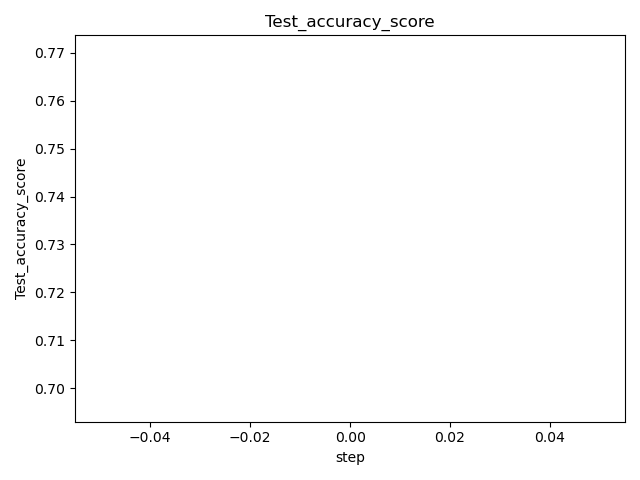

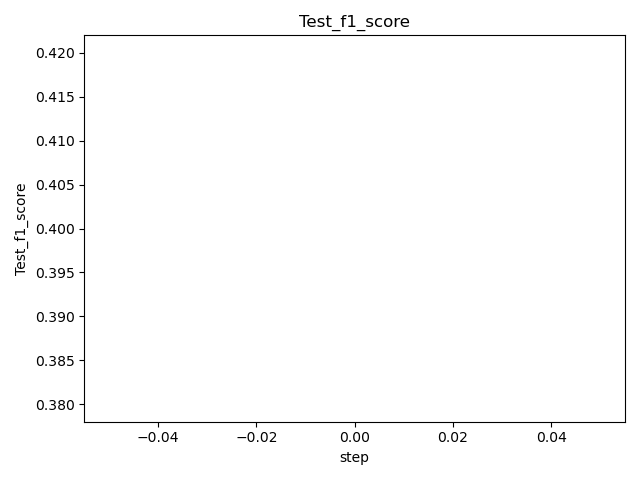

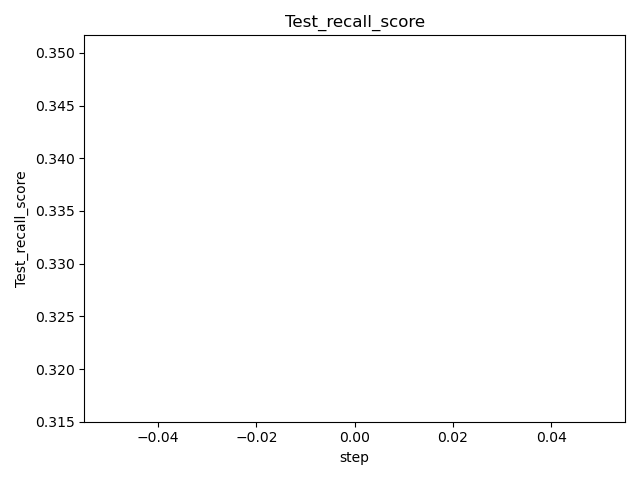

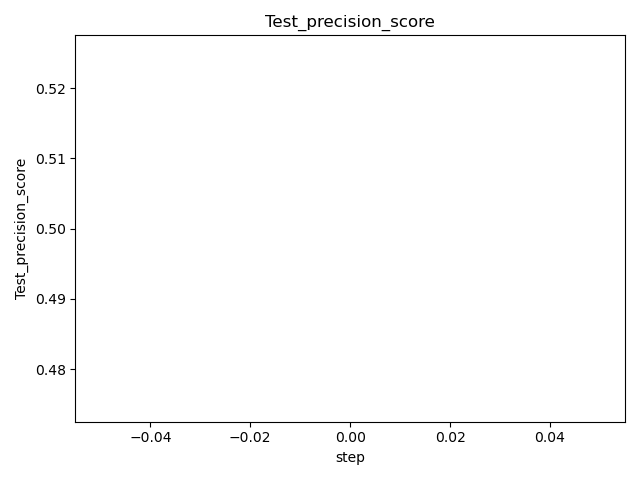

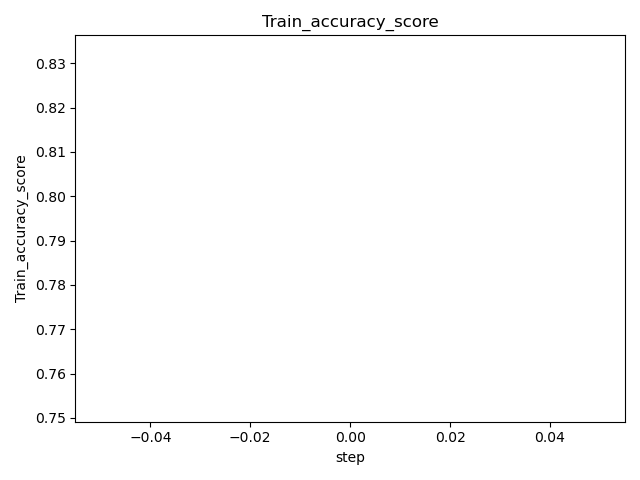

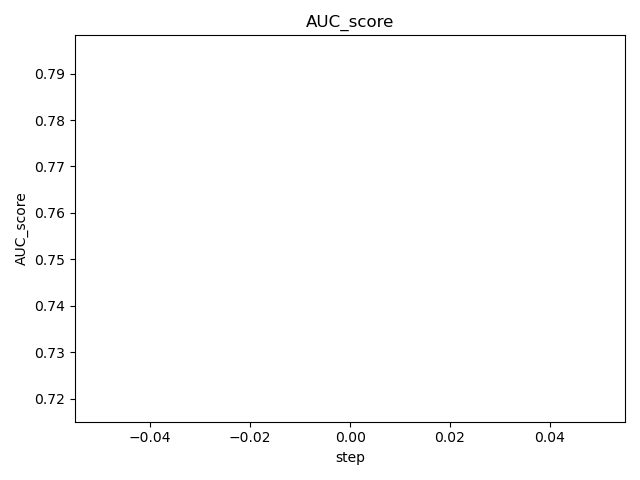



	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/Customertravel_org.csv
/Users/loonycorn/anaconda3/lib/python3.10/site-packages/dvc_render/vega.py:98: UserWarning: `generate_markdown` can only be used with `LinearTemplate`
  warn("`generate_markdown` can only be used with `LinearTemplate`")


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from dvclive import Live
lr_model = LogisticRegression()
#lr_model = LogisticRegression(class_weight = 'balanced')
    
pipe_lr = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', lr_model)])
model_params = lr_model.get_params()
print(model_params)
pipe_lr.fit(X_train, y_train)
 
predictions = pipe_lr.predict(X_test)
predictions_predict_prob = pipe_lr.predict_proba(X_test)
    
train_accuracy_score = pipe_lr.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
    
with Live(save_dvc_exp = True, report = 'notebook', exp_message = 'LogisticRegressionClassifier') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score',train_accuracy_score)
    live.log_metric('Test_accuracy_score',test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_metric('AUC_score', auc_score)
    
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')
    

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


# DVC Report

params.yaml

|   C | class_weight   | dual   | fit_intercept   |   intercept_scaling | l1_ratio   |   max_iter | multi_class   | n_jobs   | penalty   | random_state   | solver   |    tol |   verbose | warm_start   |
|-----|----------------|--------|-----------------|---------------------|------------|------------|---------------|----------|-----------|----------------|----------|--------|-----------|--------------|
|   1 | balanced       | False  | True            |                   1 |            |        100 | auto          |          | l2        |                | lbfgs    | 0.0001 |         0 | False        |

metrics.json

|   Train_accuracy_score |   Test_accuracy_score |   Test_precision_score |   Test_recall_score |   Test_f1_score |   AUC_score |
|------------------------|-----------------------|------------------------|---------------------|-----------------|-------------|
|               0.711485 |              0.722222 |               0.482759 |            0.583333 |        0.528302 |    0.751578 |

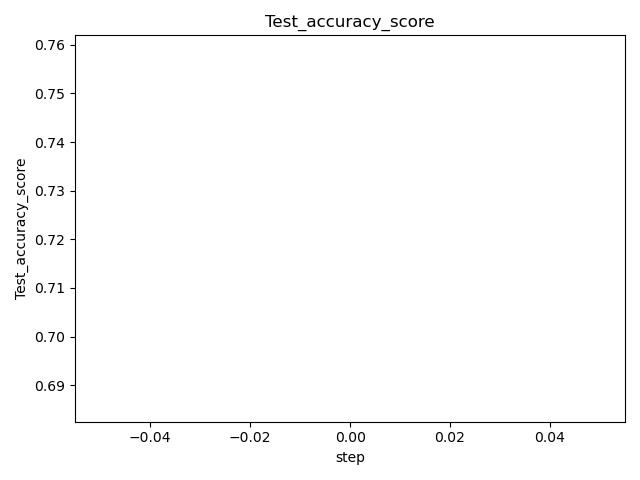

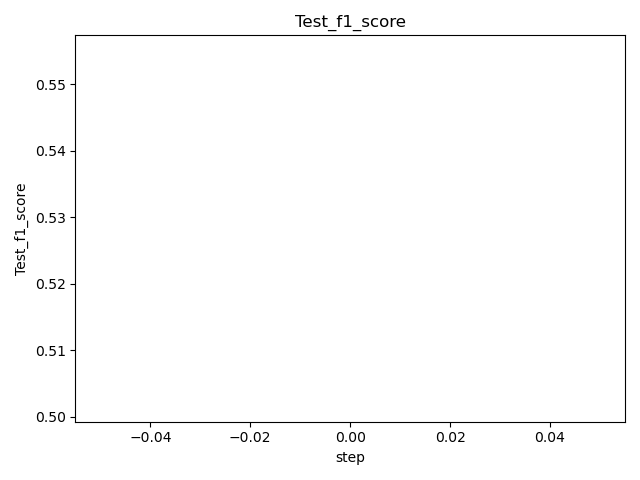

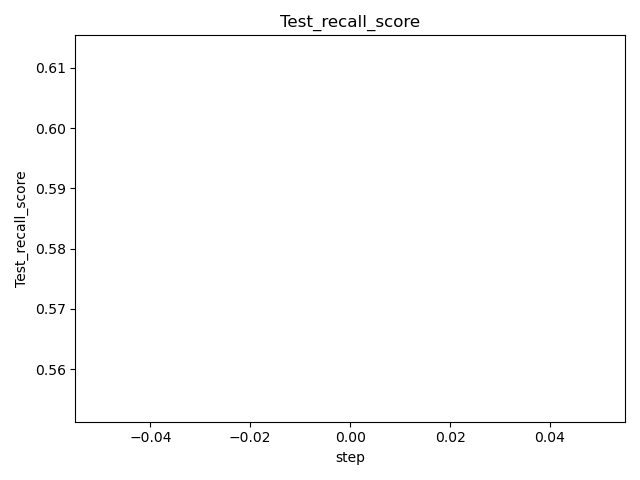

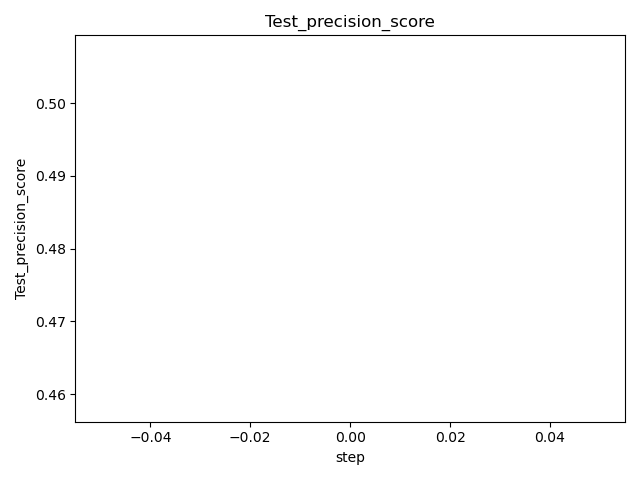

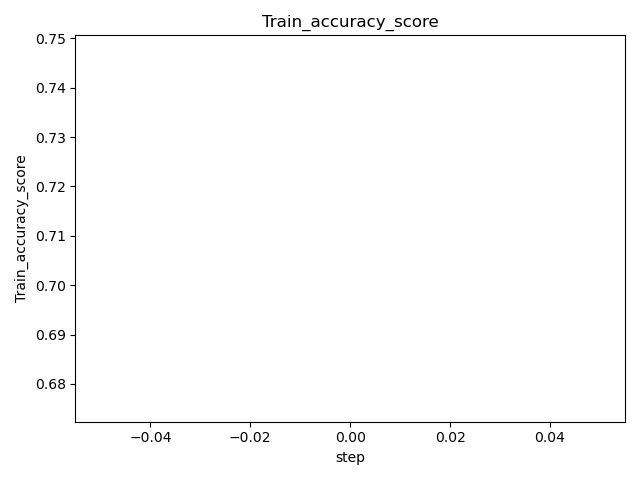

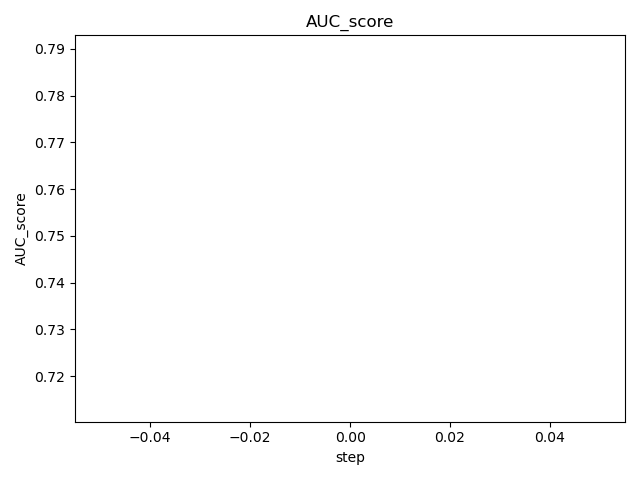



	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/Customertravel_org.csv
/Users/loonycorn/anaconda3/lib/python3.10/site-packages/dvc_render/vega.py:98: UserWarning: `generate_markdown` can only be used with `LinearTemplate`
  warn("`generate_markdown` can only be used with `LinearTemplate`")


In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from dvclive import Live
#lr_model = LogisticRegression()
lr_model = LogisticRegression(class_weight = 'balanced')
    
pipe_lr = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', lr_model)])
model_params = lr_model.get_params()
print(model_params)
pipe_lr.fit(X_train, y_train)
 
predictions = pipe_lr.predict(X_test)
predictions_predict_prob = pipe_lr.predict_proba(X_test)
    
train_accuracy_score = pipe_lr.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
    
with Live(save_dvc_exp = True, report = 'notebook', exp_message = 'LogisticRegressionClassifier_balanced_class_weight') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score',train_accuracy_score)
    live.log_metric('Test_accuracy_score',test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_metric('AUC_score', auc_score)
    
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')
    

RandomForest Model is trained and parameters and metrics are logged.It can easily seen that this experiment's performance is quite better than Logistic Regression Experiment.


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# DVC Report

params.yaml

| bootstrap   |   ccp_alpha | class_weight   | criterion   | max_depth   | max_features   | max_leaf_nodes   | max_samples   |   min_impurity_decrease |   min_samples_leaf |   min_samples_split |   min_weight_fraction_leaf |   n_estimators | n_jobs   | oob_score   | random_state   |   verbose | warm_start   |
|-------------|-------------|----------------|-------------|-------------|----------------|------------------|---------------|-------------------------|--------------------|---------------------|----------------------------|----------------|----------|-------------|----------------|-----------|--------------|
| True        |           0 |                | gini        |             | sqrt           |                  |               |                       0 |                  1 |                   2 |                          0 |            100 |          | False       |                |         0 | False        |

metrics.json

|   Train_accuracy_score |   Test_accuracy_score |   Test_precision_score |   Test_recall_score |   Test_f1_score |   AUC_score |
|------------------------|-----------------------|------------------------|---------------------|-----------------|-------------|
|               0.960784 |              0.766667 |                   0.56 |            0.583333 |        0.571429 |     0.83428 |

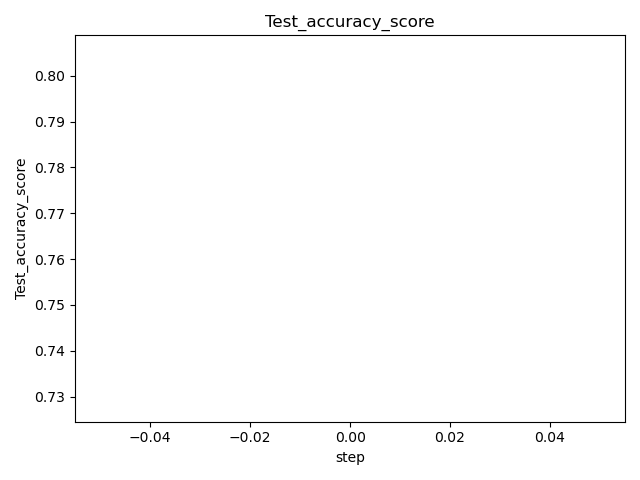

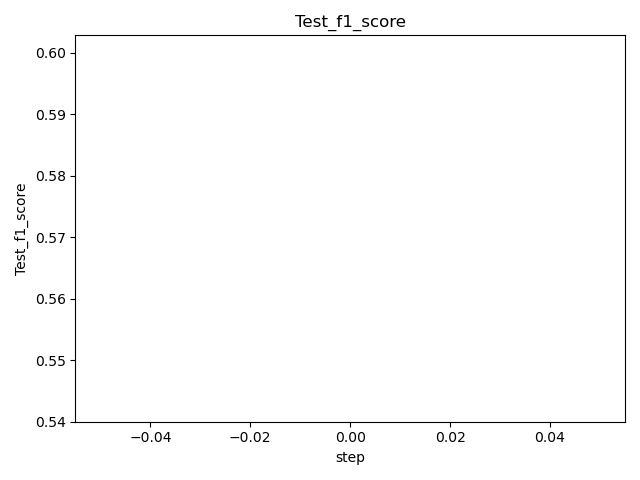

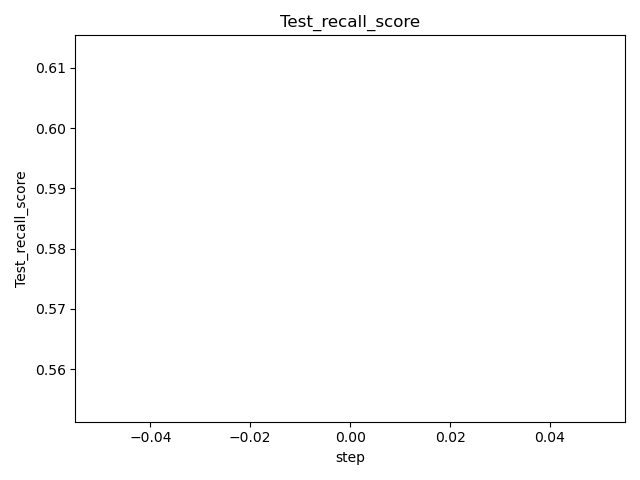

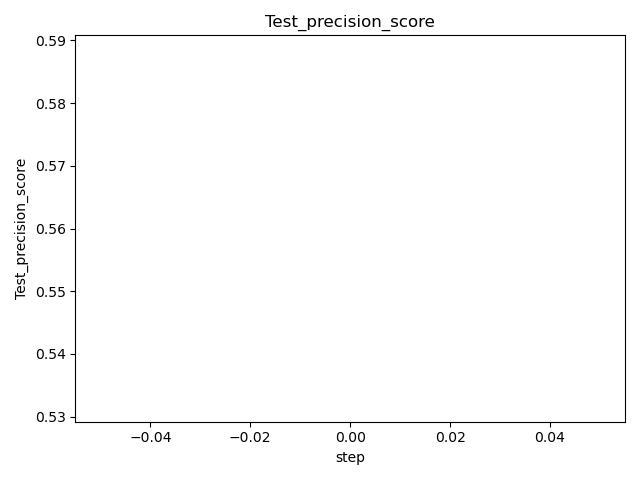

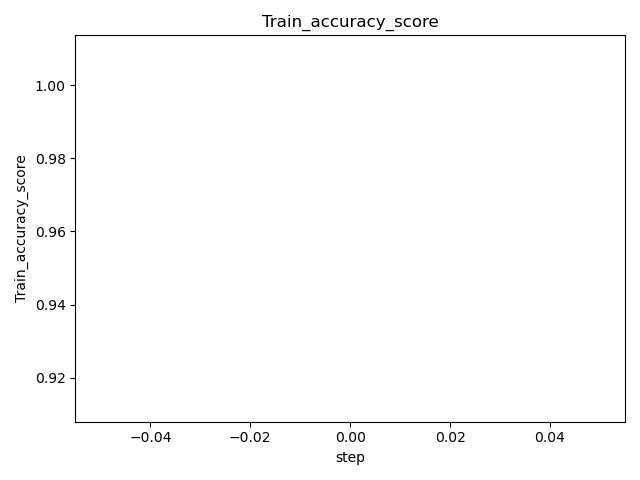

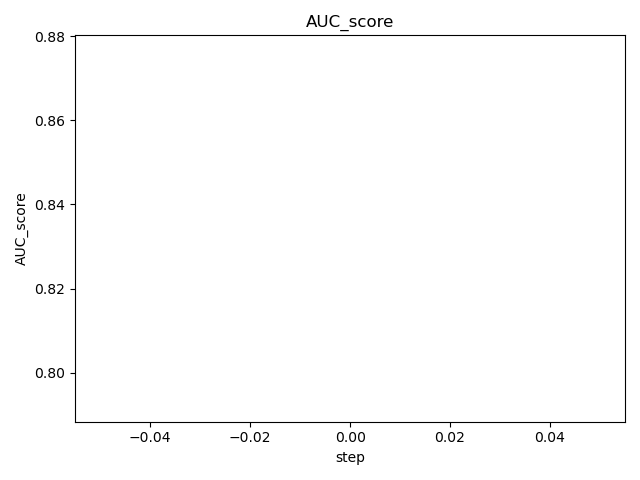



	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/Customertravel_org.csv
/Users/loonycorn/anaconda3/lib/python3.10/site-packages/dvc_render/vega.py:98: UserWarning: `generate_markdown` can only be used with `LinearTemplate`
  warn("`generate_markdown` can only be used with `LinearTemplate`")


In [65]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
#rf_model = RandomForestClassifier(class_weight = 'balanced')
    
pipe_rf = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', rf_model)])
model_params = rf_model.get_params()
print(model_params)
pipe_rf.fit(X_train, y_train)

predictions = pipe_rf.predict(X_test)
predictions_predict_prob = pipe_rf.predict_proba(X_test)
    
train_accuracy_score = pipe_rf.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
   
with Live(save_dvc_exp = True, report = 'notebook', exp_message = 'RFClassifier') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score',train_accuracy_score)
    live.log_metric('Test_accuracy_score',test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_metric('AUC_score', auc_score)
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')
    

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# DVC Report

params.yaml

| bootstrap   |   ccp_alpha | class_weight   | criterion   | max_depth   | max_features   | max_leaf_nodes   | max_samples   |   min_impurity_decrease |   min_samples_leaf |   min_samples_split |   min_weight_fraction_leaf |   n_estimators | n_jobs   | oob_score   | random_state   |   verbose | warm_start   |
|-------------|-------------|----------------|-------------|-------------|----------------|------------------|---------------|-------------------------|--------------------|---------------------|----------------------------|----------------|----------|-------------|----------------|-----------|--------------|
| True        |           0 | balanced       | gini        |             | sqrt           |                  |               |                       0 |                  1 |                   2 |                          0 |            100 |          | False       |                |         0 | False        |

metrics.json

|   Train_accuracy_score |   Test_accuracy_score |   Test_precision_score |   Test_recall_score |   Test_f1_score |   AUC_score |
|------------------------|-----------------------|------------------------|---------------------|-----------------|-------------|
|               0.960784 |              0.733333 |                    0.5 |            0.541667 |            0.52 |     0.81976 |

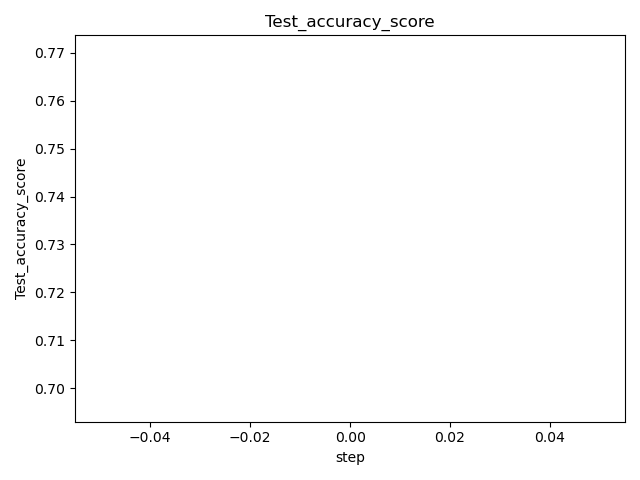

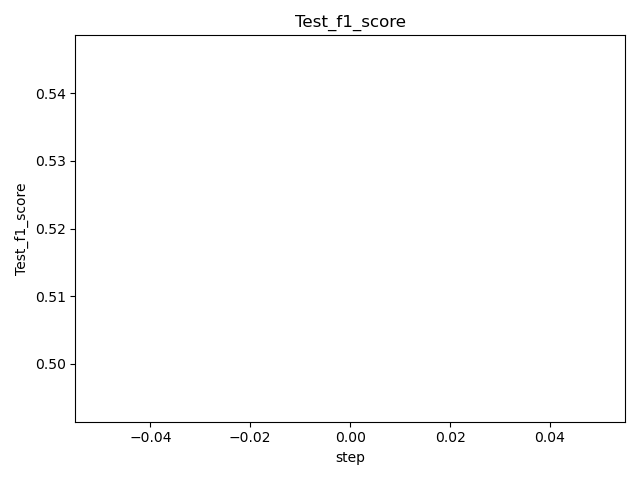

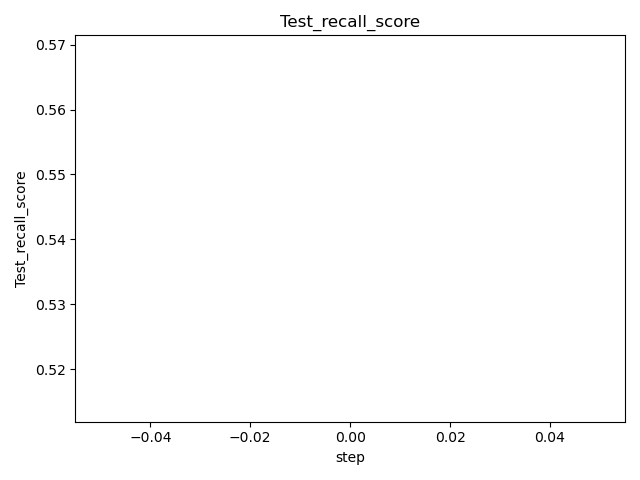

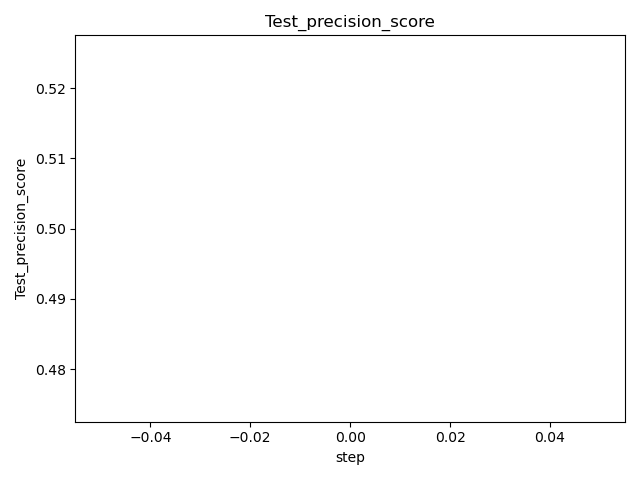

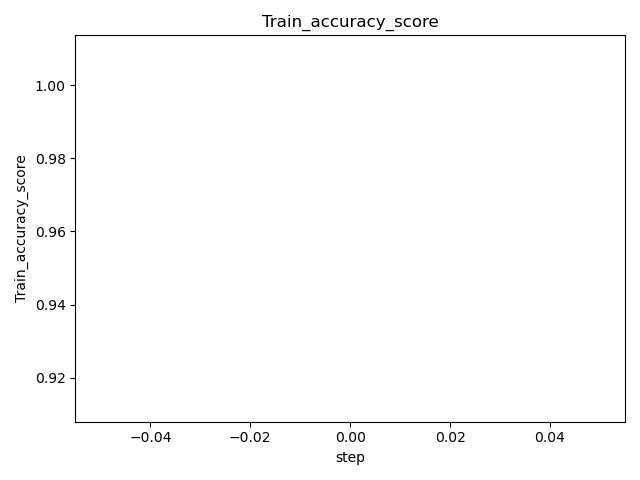

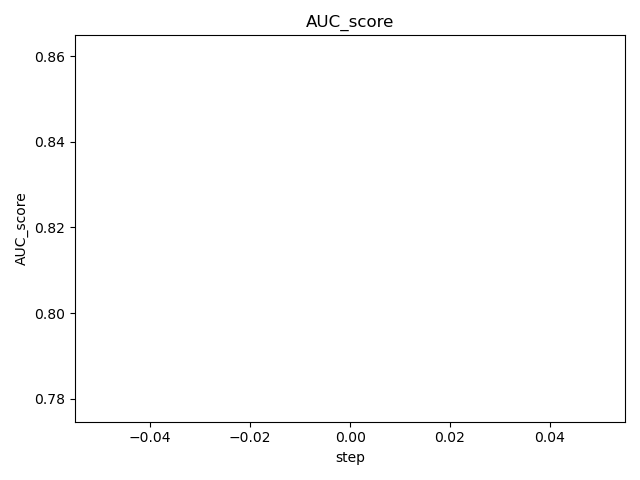



	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/Customertravel_org.csv
/Users/loonycorn/anaconda3/lib/python3.10/site-packages/dvc_render/vega.py:98: UserWarning: `generate_markdown` can only be used with `LinearTemplate`
  warn("`generate_markdown` can only be used with `LinearTemplate`")


In [66]:
from sklearn.ensemble import RandomForestClassifier
#rf_model = RandomForestClassifier()
rf_model = RandomForestClassifier(class_weight = 'balanced')
    
pipe_rf = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', rf_model)])
model_params = rf_model.get_params()
print(model_params)
pipe_rf.fit(X_train, y_train)

predictions = pipe_rf.predict(X_test)
predictions_predict_prob = pipe_rf.predict_proba(X_test)
    
train_accuracy_score = pipe_rf.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
   
with Live(save_dvc_exp = True, report = 'notebook', exp_message = 'RFClassifier_balanced_class_weight') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score',train_accuracy_score)
    live.log_metric('Test_accuracy_score',test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_metric('AUC_score', auc_score)
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# DVC Report

params.yaml

| bootstrap   |   ccp_alpha | class_weight   | criterion   | max_depth   | max_features   | max_leaf_nodes   | max_samples   |   min_impurity_decrease |   min_samples_leaf |   min_samples_split |   min_weight_fraction_leaf |   n_estimators | n_jobs   | oob_score   | random_state   |   verbose | warm_start   |
|-------------|-------------|----------------|-------------|-------------|----------------|------------------|---------------|-------------------------|--------------------|---------------------|----------------------------|----------------|----------|-------------|----------------|-----------|--------------|
| True        |           0 |                | gini        |             | sqrt           |                  |               |                       0 |                  1 |                   2 |                          0 |            100 |          | False       |                |         0 | False        |

metrics.json

|   Train_accuracy_score |   Test_accuracy_score |   Test_precision_score |   Test_recall_score |   Test_f1_score |   AUC_score |
|------------------------|-----------------------|------------------------|---------------------|-----------------|-------------|
|               0.960784 |              0.744444 |               0.521739 |                 0.5 |        0.510638 |    0.827967 |

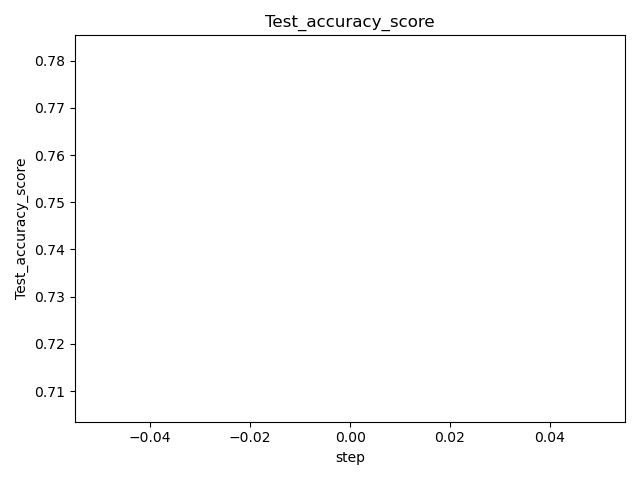

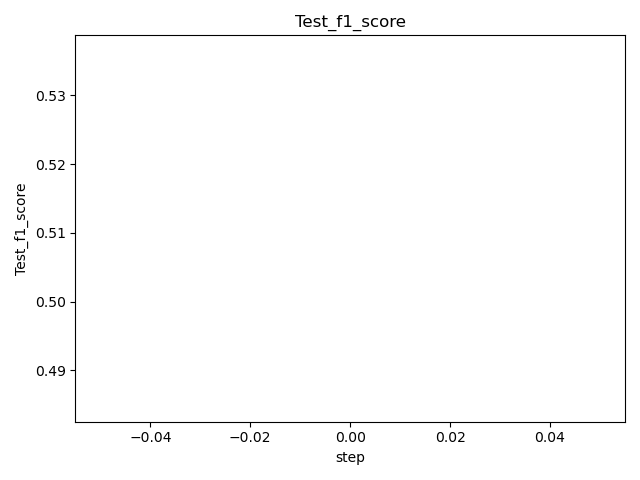

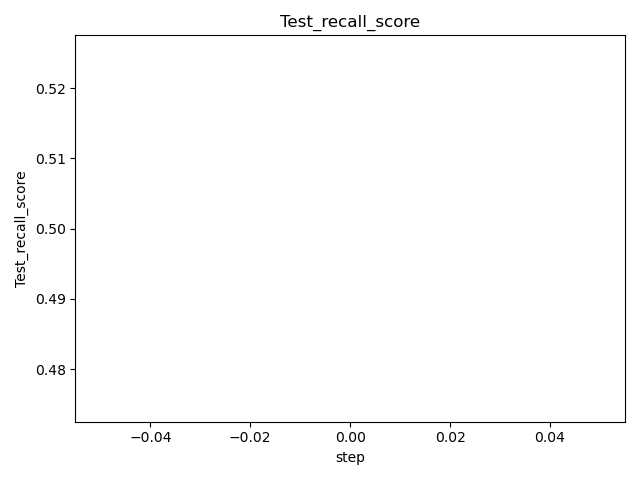

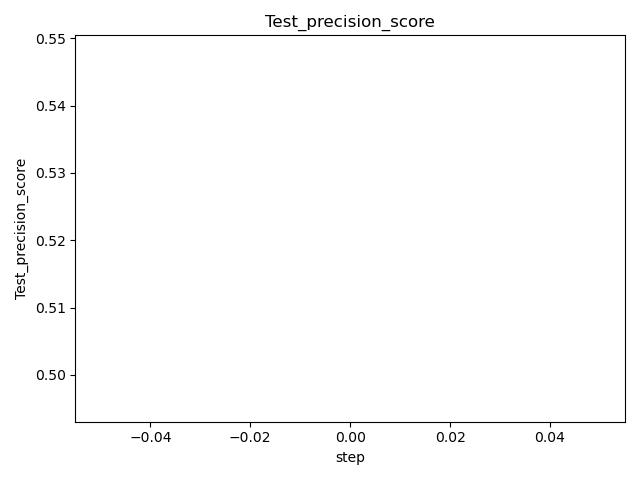

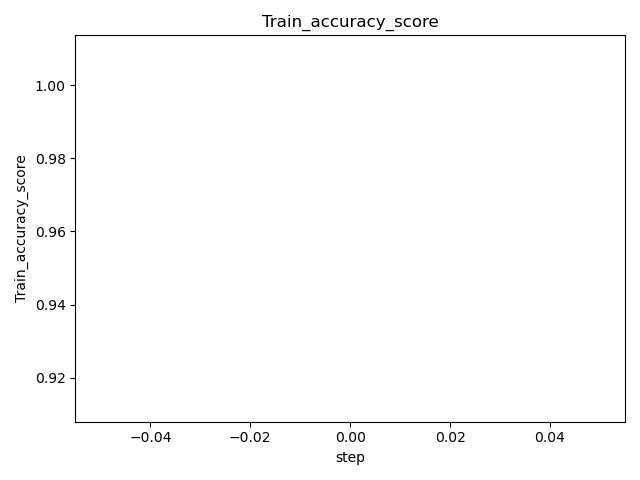

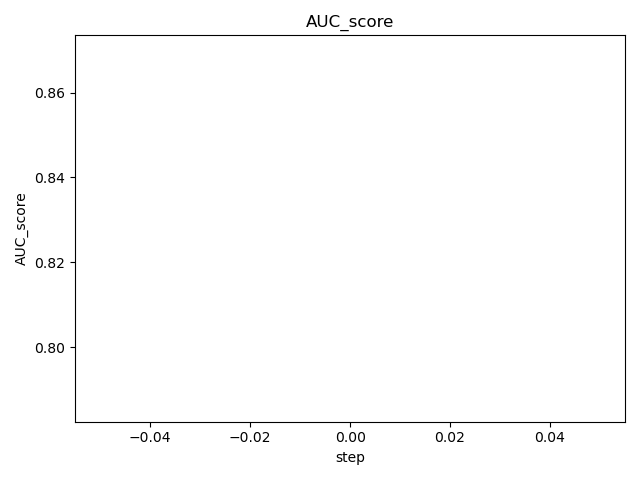



	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/Customertravel_org.csv
/Users/loonycorn/anaconda3/lib/python3.10/site-packages/dvc_render/vega.py:98: UserWarning: `generate_markdown` can only be used with `LinearTemplate`
  warn("`generate_markdown` can only be used with `LinearTemplate`")


In [50]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
#rf_model = RandomForestClassifier(class_weight = 'balanced')
    
pipe_rf = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', rf_model)])
model_params = rf_model.get_params()
print(model_params)
pipe_rf.fit(X_train, y_train)

predictions = pipe_rf.predict(X_test)
predictions_predict_prob = pipe_rf.predict_proba(X_test)
    
train_accuracy_score = pipe_rf.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
   
with Live(save_dvc_exp = True, report = 'notebook', exp_message = 'RFClassifier_default_params') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score',train_accuracy_score)
    live.log_metric('Test_accuracy_score',test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_metric('AUC_score', auc_score)
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')

In [68]:
from sklearn.svm import SVC

svc_model = SVC(class_weight = 'balanced')
    
pipe_svc = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', svc_model )])
pipe_svc.fit(X_train, y_train)
model_params = svc_model.get_params()
print(model_params)
predictions =  pipe_svc.predict(X_test)
    
train_accuracy_score = pipe_svc.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score}
   
with Live(save_dvc_exp = True, exp_message = 'SVClassifier_class_weight_balanced') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score', train_accuracy_score)
    live.log_metric('Test_accuracy_score', test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/Customertravel_org.csv


In [48]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [77]:
from xgboost.sklearn import XGBClassifier
#xgb_model = XGBClassifier()
xgb_model = XGBClassifier(scale_pos_weight=2)
    
pipe_xgb = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', xgb_model )])
pipe_xgb.fit(X_train, y_train)
model_params = xgb_model.get_params()
print(model_params)
predictions =  pipe_xgb.predict(X_test)
predictions_predict_prob = pipe_xgb.predict_proba(X_test)
    
train_accuracy_score = pipe_xgb.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
   
with Live(save_dvc_exp = True, exp_message = 'XGBoostingClassifier') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score', train_accuracy_score)
    live.log_metric('Test_accuracy_score', test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_metric('AUC_score', auc_score)
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 2, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/Customertravel_org.csv


In [71]:
pip install optuna

     l     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/390.6 kB ? eta -:--:--━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/390.6 kB 2.2 MB/s eta 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━ 245.8/390.6 kB 3.0 MB/s eta 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 389.1/390.6 kB 3.5 MB/s eta 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 2.8 MB/s eta 0:00:00
     l     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/224.5 kB ? eta -:--:--━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 8.9 MB/s eta 0:00:00
     l     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/78.7 kB ? eta -:--:--━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
from xgboost.sklearn import XGBClassifier

In [12]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 15, log = True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log = True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, log = True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10, log = True),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
    }

    # Fit the model
    xgb_model = XGBClassifier(**params)
    
    pipe_xgb = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', xgb_model )])
    pipe_xgb.fit(X_train, y_train)

    # Make predictions
    predictions = pipe_xgb.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, predictions)
    return f1

In [13]:
from dvclive.optuna import DVCLiveCallback

In [14]:
import optuna
study = optuna.create_study(direction = 'maximize')

[I 2023-06-21 10:24:12,168] A new study created in memory with name: no-name-d09e4c38-2a17-4593-b401-f1663563f66d


In [17]:
study.optimize(objective, n_trials = 32, callbacks = [DVCLiveCallback()])

[W 2023-06-21 10:25:24,938] Trial 1 failed with parameters: {'max_depth': 1, 'learning_rate': 0.03907528272789382, 'n_estimators': 273, 'min_child_weight': 2, 'lambda': 7.8560594476012175, 'alpha': 3.7066755898742003} because of the following error: NameError("name 'f1_score' is not defined").
Traceback (most recent call last):
  File "/Users/loonycorn/anaconda3/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/pn/720vmx4d779f96nxdz7tlk400000gn/T/ipykernel_989/2677387536.py", line 23, in objective
    f1 = f1_score(y_test, predictions)
NameError: name 'f1_score' is not defined
[W 2023-06-21 10:25:24,940] Trial 1 failed with value None.


NameError: name 'f1_score' is not defined

In [88]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 64
Best trial:
  Value: 0.679245283018868
  Params: 
    max_depth: 5
    learning_rate: 0.33927426770408403
    n_estimators: 309
    min_child_weight: 1
    gamma: 0.6075316981528571
    subsample: 0.9208939908282296
    colsample_bytree: 0.8384438075174956
    reg_alpha: 0.9487296984782645
    reg_lambda: 0.10542804875610112


In [ ]:
params = trial.params

In [ ]:
model = XGBClassifier(**params)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)